<a href="https://colab.research.google.com/github/JiananAlvin/ee411_fundamentals_of_inference_and_learning/blob/main/hw2_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: mask detection for the next pandemic
You heard rumors from biology department of EPFL about a new version of a corona virus spreading out next year, already called COVID-25. The virus is so dangerous that you are asked to develop a mask detection system to be deployed in all public places. The system should be able to detect if a person is wearing a mask or not. You are given a dataset of images of people with and without masks. Your task is to develop a machine learning model that can detect if a person is wearing a mask or not.

**IMPORTANT NOTE:** The evaluation of this homework will be done on an hidden dataset. It is important that your notebook runs without errors, otherwise we will not be able to evaluate some questions, resulting in a grade 0 for that part. Make sure to double check your code before submitting the notebook. We provide a simple `evaluate` function that you can use to make sure that all the necessary functions are implemented correctly; the function will warn you if it detects that a good prediction cannot be made. `evaluate` takes just one argument: the `scikit-learn` model that you have trained. It expects the model to have a `predict` method that works on a numpy array.

In [ ]:
from evaluation import evaluate

## Data loading and preprocessing
The dataset consists in $n$ images of dimension 128x128 pixels. Each pixel is represented by 3 values (RGB). The dataset is divided in two classes: 0 for people with the mask and 1 for people without the mask.

In [ ]:
import numpy as np
import sklearn

def load_file(file):
    with np.load('data/'+file+'.npz') as data:
        X = data['X']
        y = data['y']
    return X, y

X, y = load_file('train')
print(X.shape, y.shape)
print(f"Data type: {X.dtype}, Min: {X.min()}, Max: {X.max()}")

(188, 3, 128, 128) (188,)
Data type: float32, Min: 0.0, Max: 1.0


**Question 1.** Plot few images, and check the distribution of the labels.

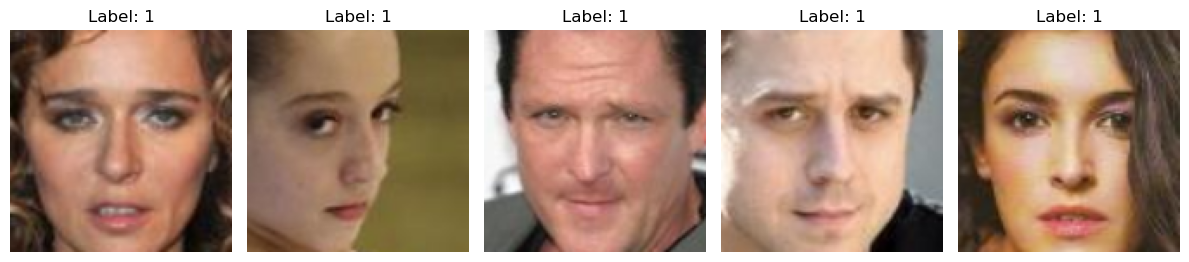

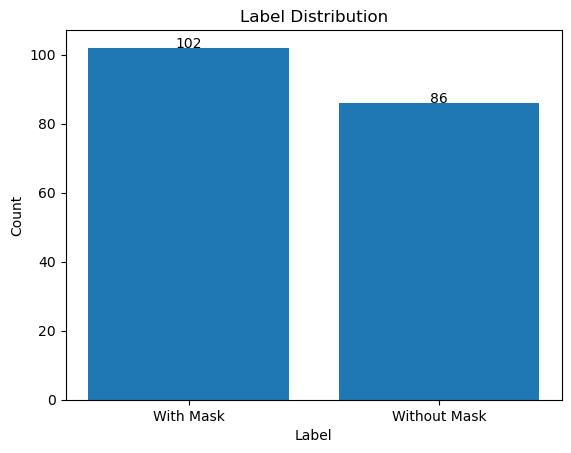

In [ ]:
import matplotlib.pyplot as plt

n = X.shape[0]

# Visualizing the images
def plot_images(X, y, num_images=5):
    """Plot a few images with their labels."""
    # Scale pixel values from [0.0, 1.0] to [0, 255]
    # Otherwise it's all black.
    X = (X * 255).astype('uint8')

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Transpose image for correct orientation (Channels-Last)
        img = np.transpose(X[i], (1, 2, 0))
        plt.imshow(img)
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot a few images
plot_images(X, y)

# Analyzing the label distribution
def plot_label_distribution(y):
    """Plot the distribution of labels."""
    labels, counts = np.unique(y, return_counts=True)
    plt.bar(labels, counts)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title("Label Distribution")
    plt.xticks(labels, ["With Mask", "Without Mask"])
    for i, count in enumerate(counts):
        plt.text(i, count + 0.05, str(count), ha='center', fontsize=10, color='black')
    plt.show()

# Example usage
plot_label_distribution(y)

**Question 2.** Reshape each image in the dataset to a flat vector. Split the dataset into training and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

test_size = 0.2

# Flatten each image to a 1D vector
X_flat = X.reshape(X.shape[0], -1)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=test_size, random_state=42)

# Print shapes to confirm
print(f"Training set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Test set: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")

Training set: X_train shape = (150, 49152), y_train shape = (150,)
Test set: X_test shape = (38, 49152), y_test shape = (38,)


## Logistic regression

**Question 3.** Train a logistic regression model on the training data, comparing the accuracies of $\ell_1$ and $\ell_2$ penalties. What is the train and test accuracy of the model?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train and evaluate logistic regression with L1 penalty
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
model_l1.fit(X_train, y_train)

y_train_pred_l1 = model_l1.predict(X_train)
y_test_pred_l1 = model_l1.predict(X_test)

train_accuracy_l1 = accuracy_score(y_train, y_train_pred_l1)
test_accuracy_l1 = accuracy_score(y_test, y_test_pred_l1)

print(f"L1 penalty: Train accuracy = {train_accuracy_l1:.4f}, Test accuracy = {test_accuracy_l1:.4f}")

# Train and evaluate logistic regression with L2 penalty
model_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, random_state=42)
model_l2.fit(X_train, y_train)

y_train_pred_l2 = model_l2.predict(X_train)
y_test_pred_l2 = model_l2.predict(X_test)

train_accuracy_l2 = accuracy_score(y_train, y_train_pred_l2)
test_accuracy_l2 = accuracy_score(y_test, y_test_pred_l2)

print(f"L2 penalty: Train accuracy = {train_accuracy_l2:.4f}, Test accuracy = {test_accuracy_l2:.4f}")

model = model_l1 if test_accuracy_l1 > test_accuracy_l2 else model_l2
print(f"Selected model: {'L1' if test_accuracy_l1 > test_accuracy_l2 else 'L2'}")

L1 penalty: Train accuracy = 0.9933, Test accuracy = 0.8947


L2 penalty: Train accuracy = 1.0000, Test accuracy = 0.9211
Selected model: L2


In [ ]:
# Evaluate the model
evaluate(model)
# Make sure the line above runs without errors before submitting your solution!

All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9840425531914894


**Question 4.** Make a more extensive search of possible Logistic Regressors. Crossvalidate the following parameters:
- penalty: `['l1', 'l2']`
- $C$: range from $10^{-3}$ to $10^3$.


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
}

# Create the Logistic Regression model
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Set up GridSearchCV
grid_search_cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=2
)

# Perform the grid search on the training data
grid_search_cv.fit(X_train, y_train)

# Best model and parameters
logistic_model = grid_search_cv.best_estimator_
print(f"Best Parameters: {grid_search_cv.best_params_}")
print(f"Best Cross-Validation accuracy: {grid_search_cv.best_score_:.4f}")

# Evaluate the best model on the test set
test_accuracy_logistic_org = logistic_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy_logistic_org:.4f}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits


Best Parameters: {'C': 1.0, 'penalty': 'l1'}
Best Cross-Validation accuracy: 0.8867
Test accuracy: 0.8947


In [ ]:
# Official evaluation!
evaluate(logistic_model)
# Make sure the line above runs without errors before submitting your solution!

All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.973404255319149


## SVM
**Question 4.** Train a linear SVM model on the training data and crossvalidate the parameter $C$.

In [ ]:
from sklearn.svm import LinearSVC

# Define the parameter grid for C
param_grid = {'C': np.logspace(-3, 3, 7)}

# Create the LinearSVC model
model = LinearSVC(max_iter=1000, random_state=42)

# Set up GridSearchCV
grid_search_cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=2
)

# Perform the grid search on the training data
grid_search_cv.fit(X_train, y_train)

# Get the best model and parameters
svm_model = grid_search_cv.best_estimator_
print(f"Best Parameters: {grid_search_cv.best_params_}")
print(f"Best Cross-Validation accuracy: {grid_search_cv.best_score_:.4f}")

# Evaluate the best SVM model on the test set
test_accuracy_svm_org = svm_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy_svm_org:.4f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/jiaxu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/jiaxu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/jiaxu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/jiaxu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/home/jiaxu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameters: {'C': 0.001}
Best Cross-Validation accuracy: 0.8400
Test accuracy: 0.9211


In [ ]:
# Official evaluation!
evaluate(svm_model)
# Make sure the line above runs without errors before submitting your solution!

All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9840425531914894


## Random Forest

**Question 5.** Train a Random Forest model on the training data and crossvalidate the parameters:
- `n_estimators`
- `max_depth`
- `criteria`



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40, None],  # Trees are grown to their maximum possible depth
    'criterion': ['gini', 'entropy']
}

# Create the Random Forest model
model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search_cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=2
)

# Perform the grid search on the training data
grid_search_cv.fit(X_train, y_train)

# Get the best model and parameters
rf_model = grid_search_cv.best_estimator_
print(f"Best Parameters: {grid_search_cv.best_params_}")
print(f"Best Cross-Validation accuracy: {grid_search_cv.best_score_:.4f}")

# Evaluate the best Random Forest model on the test set
test_accuracy_rf_org = rf_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy_rf_org:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 300}
Best Cross-Validation accuracy: 0.9200
Test accuracy: 0.8947


In [ ]:
# Official evaluation!
evaluate(rf_model)
# Make sure the line above runs without errors before submitting your solution!

All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9787234042553191


## Extra data
Digging in his archive, EPFL Health autorities found a another dataset of images with the same format. This dataset is called `extratrain`. Use this dataset to improve the performance of your models.

In [ ]:
X_extra, y_extra = load_file('extra')

**Question 6.** Is this new dataset good? What problem does it have compared to the original dataset, if any?

(4629, 3, 128, 128) (4629,)


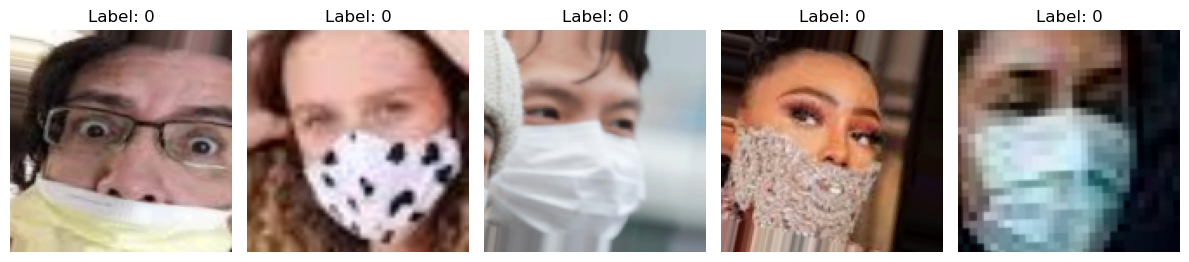

The number of samples with mask: 4629.
The number of samples without mask: 0.


In [ ]:
# Print the shapes of the extra data
print(X_extra.shape, y_extra.shape)

# Plot a few images
plot_images(X_extra, y_extra)

# Out put the label distribution
print(f'The number of samples with mask: {sum(y_extra == 0)}.')
print(f'The number of samples without mask: {sum(y_extra == 1)}.')

This new dataset is not good. The number of samples with and without mask are 102:86 in the original dataset. However, the new dataset only  contains samples with masks.

**Question 7.** Evaluate the performance of the cross-validated models you found in the previous questions on the new dataset. Is the performance better or worse? Why?

In [ ]:
# Flatten each image to a 1D vector
X_extra = X_extra.reshape(X_extra.shape[0], -1)

# Logisitic Regression
test_accuracy_logistic_extra = logistic_model.score(X_extra, y_extra)
print(f"Test accuracy of the logistic regression model: {test_accuracy_logistic_extra:.4f}")
if test_accuracy_logistic_extra < test_accuracy_logistic_org:
    print("The performance of logistic regression model is worse.")
else:
    print("The performance of logistic regression model is better.")

# SVM
test_accuracy_svm_extra = svm_model.score(X_extra, y_extra)
print(f"Test accuracy of the SVM model: {test_accuracy_svm_extra:.4f}")
if test_accuracy_svm_extra < test_accuracy_svm_org:
    print("The performance of SVM model is worse.")
else:
    print("The performance of SVM model is better.")

# Random Forest
test_accuracy_rf_extra = rf_model.score(X_extra, y_extra)
print(f"Test accuracy of the Random Forest model: {test_accuracy_rf_extra:.4f}")
if test_accuracy_rf_extra < test_accuracy_rf_org:
    print("The performance of Random Forest model is worse.")
else:
    print("The performance of Random Forest model is better.")



Test accuracy of the logistic regression model: 0.8388
The performance of logistic regression model is worse.


Test accuracy of the SVM model: 0.8449
The performance of SVM model is worse.
Test accuracy of the Random Forest model: 0.8983
The performance of Random Forest model is better.


Logistic Regression and SVM have worse performance.

Logistic Regression and SVM struggle more with imbalanced datasets because they attempt to optimize global decision boundaries for the relatively balanced dataset. If all the test samples belong to "With Mask" (0), the model still applies the same boundary learned during training. Some "With Mask" samples might fall on the other side of the boundary, where the model would incorrectly classify them as "Without Mask" (1). As a result, the performance drops because the model's boundary doesn't align perfectly with the test dataset's imbalanced distribution.

Random Forest has better performance.

Random Forest doesn’t rely on a single linear boundary. Instead, it builds multiple decision trees based on subsets of features and data. Each tree creates its own simple rules. The model combines these rules, making it more robust to imbalances and better suited to handle cases where only one class dominates the test set. It is less sensitive to the class imbalance in the test dataset compared to Logistic Regression and SVM.

**Question 8.** Train the most promising model using the new dataset, and crossvalidate. Is the performance better or worse? Why?

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [5, 10, 20, 30, None],  # Trees are grown to their maximum possible depth
    'criterion': ['gini', 'entropy']
}

# Create the Random Forest model
model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search_cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=2
)

# Perform the grid search on the training data
grid_search_cv.fit(X_extra, y_extra)

# Get the best model and parameters
newrf_model = grid_search_cv.best_estimator_
print(f"Best Parameters: {grid_search_cv.best_params_}")
print(f"Best Cross-Validation accuracy: {grid_search_cv.best_score_:.4f}")

# Evaluate the best Random Forest model on the test set
test_accuracy_newrf_extra = newrf_model.score(X_test, y_test)
print(f"Test accuracy of the new Random Forest model trained on the extra dataset: {test_accuracy_newrf_extra:.4f}")
if test_accuracy_newrf_extra < test_accuracy_rf_org:
    print("The performance of the new Random Forest model trained on the extra dataset is worse.")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 25}
Best Cross-Validation accuracy: 1.0000
Test accuracy of the new Random Forest model trained on the extra dataset: 0.4474
The performance of the new Random Forest model trained on the extra dataset is worse.


The extra dataset contains only samples with masks (label 0). During training, the model sees only one class and learns to always predict 0. This results in perfect cross-validation accuracy. Since the dataset contains only 0, predicting 0 for every sample achieves 100% accuracy during cross-validation. This also results in poor generalization. On the test set (which is relatively balanced and contains both 0 and 1), the model fails to recognize samples from the "Without Mask" (label 1) class, resulting in low accuracy.

In [ ]:
# Official evaluation!
evaluate(newrf_model)
# Make sure the line above runs without errors before submitting your solution!

All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.5425531914893617


**Question 9:** Join the `train` and `extra` datasets and repeat the previous point. What is the best model and its accuracy on the combined dataset?

In [ ]:
# Combine the train and extra datasets
X_combined = np.vstack((X_train, X_extra))
y_combined = np.hstack((y_train, y_extra))

# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [5, 10, 20, 30, 40, None],
    'criterion': ['gini', 'entropy']
}

# Create the Random Forest model
model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=2
)

# Perform the grid search on the combined training data
grid.fit(X_combined, y_combined)

# Get the best model and parameters
rf_combined_model = grid.best_estimator_
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Cross-Validation accuracy on combined dataset: {grid.best_score_:.4f}")

# Evaluate the best model on the test set
test_accuracy_rf_combined = rf_combined_model.score(X_test, y_test)
print(f"Test accuracy of the Random Forest model trained on the combined dataset: {test_accuracy_rf_combined:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 25}
Best Cross-Validation accuracy on combined dataset: 0.9885
Test accuracy of the Random Forest model trained on the combined dataset: 0.6053


In [ ]:
# Official evaluation!
evaluate(grid.best_estimator_)
# Make sure the line above runs without errors before submitting your solution!

All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9202127659574468


**Question 10:** Resample the joined dataset to solve the joined dataset "problem". Train a Random Forest with crossvalidation and discuss the results.

In [ ]:
from sklearn.utils import resample

# Separate the majority and minority classes
X_majority = X_combined[y_combined == 0]
X_minority = X_combined[y_combined == 1]
y_majority = y_combined[y_combined == 0]
y_minority = y_combined[y_combined == 1]

# Resample the minority class to match the majority class size
X_minority_upsampled, y_minority_upsampled = resample(
    X_minority, y_minority,
    replace=True,  # Oversample with replacement
    n_samples=len(X_majority),  # Match number of samples in the majority class
    random_state=42
)

# Combine the upsampled minority class with the majority class
X_resampled = np.vstack((X_majority, X_minority_upsampled))
y_resampled = np.hstack((y_majority, y_minority_upsampled))

# Shuffle the resampled dataset
shuffled_indices = np.random.permutation(len(y_resampled))
X_resampled = X_resampled[shuffled_indices]
y_resampled = y_resampled[shuffled_indices]

print(f"Resampled dataset shape: {X_resampled.shape}, {y_resampled.shape}")

Resampled dataset shape: (9428, 49152), (9428,)


In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [10, 20, 30, 40, None],
    'criterion': ['gini', 'entropy']
}

# Create the Random Forest model
model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search_cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=2
)

# Perform the grid search on the resampled training data
grid_search_cv.fit(X_resampled, y_resampled)

# Get the best model and parameters
oversampled_rf_model = grid_search_cv.best_estimator_
print(f"Best Parameters: {grid_search_cv.best_params_}")
print(f"Best Cross-Validation Accuracy on Resampled Dataset: {grid_search_cv.best_score_:.4f}")

# Evaluate the best model on the test set
test_accuracy_rf_resampled = oversampled_rf_model.score(X_test, y_test)
print(f"Test Accuracy of the Random Forest model trained on the resampled dataset: {test_accuracy_rf_resampled:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 50}
Best Cross-Validation Accuracy on Resampled Dataset: 0.9996
Test Accuracy of the Random Forest model trained on the resampled dataset: 0.7368


In [ ]:
# Official evaluation!
evaluate(oversampled_rf_model)
# Make sure the line above runs without errors before submitting your solution!

All good, you are ready for HomeWork submission! The accuracy on 'train' is:  0.9468085106382979


**Question 11:** Repeat the previous question, but this time use `LogisticRegression` as the model.

In [ ]:
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7)
}

# Create the Logistic Regression model
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Set up GridSearchCV
grid_search_cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=2
)

# Perform the grid search on the resampled training data
grid_search_cv.fit(X_resampled, y_resampled)

# Get the best model and parameters
oversampled_lr_model = grid_search_cv.best_estimator_
print(f"Best Parameters: {grid_search_cv.best_params_}")
print(f"Best Cross-Validation Accuracy on Resampled Dataset: {grid_search_cv.best_score_:.4f}")

# Evaluate the best model on the test set
test_accuracy_lr_resampled = oversampled_lr_model.score(X_test, y_test)
print(f"Test Accuracy of the Logistic Regression model trained on the resampled dataset: {test_accuracy_lr_resampled:.4f}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits


Best Parameters: {'C': 1000.0, 'penalty': 'l1'}
Best Cross-Validation Accuracy on Resampled Dataset: 0.9940
Test Accuracy of the Logistic Regression model trained on the resampled dataset: 0.9474


**Question 12:** Train the best model you can given the data available. Describe your technique and justify your choices.

**Question Bonus:** You have been told that is much more important to detect people without masks than people with masks. How would you change your model to take this into account?